In [1]:
import os
from pyspark.sql import SparkSession

jar_folder = "/opt/extra_jars"
jars = [os.path.join(jar_folder, f) for f in os.listdir(jar_folder) if f.endswith('.jar')]
jars_string = ",".join(jars)

if 'spark' in locals():
    spark.stop()

spark = (SparkSession.builder
    .appName("EDAWeatherAndDelay")
    .master("spark://spark-master:7077")
    .config("spark.jars", jars_string)
    .config("spark.mongodb.read.connection.uri", "mongodb://mongodb:27017/big_data_austria")
    .getOrCreate())


df_weather = (spark.read
    .format("mongodb")
    .option("collection", "weather_cleaned")
    .load())

df_incidents = (spark.read
    .format("mongodb")
    .option("collection", "wienerlinien_cleaned")
    .load())


In [2]:
from pyspark.sql import functions as F

df_incidents = df_incidents.withColumn("weekday_name", F.date_format("timestart", "EEEE")) \
                           .withColumn("weekday_num", F.dayofweek("timestart")) \
                        .withColumn("weekday_num", F.when(F.dayofweek("timestart") == 1, 7).otherwise(F.dayofweek("timestart") - 1))

df_incidents.select("timestart", "weekday_name", "weekday_num").show(5)

+-------------------+------------+-----------+
|          timestart|weekday_name|weekday_num|
+-------------------+------------+-----------+
|2025-11-03 13:19:24|      Monday|          1|
|2025-11-03 13:33:31|      Monday|          1|
|2025-11-03 14:15:00|      Monday|          1|
|2025-11-03 14:20:00|      Monday|          1|
|2025-11-03 15:20:00|      Monday|          1|
+-------------------+------------+-----------+
only showing top 5 rows



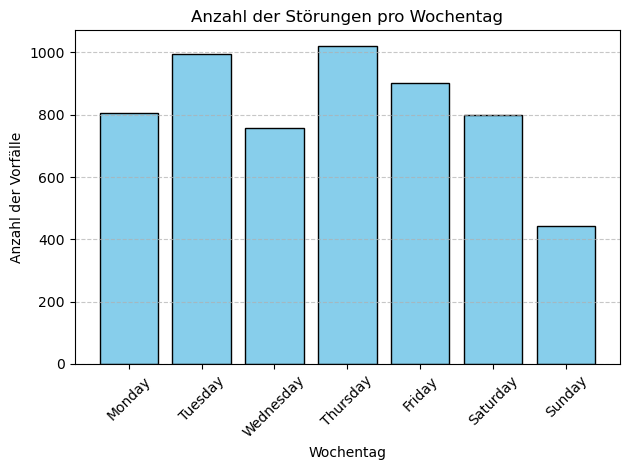

In [3]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

plot_path = "plots"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
    print(f"Ordner '{plot_path}' wurde erstellt.")

weekday_counts = df_incidents.groupBy("weekday_num", "weekday_name") \
    .count() \
    .orderBy("weekday_num") \
    .toPandas()

plt.bar(weekday_counts['weekday_name'], weekday_counts['count'], color='skyblue', edgecolor='black')
plt.title('Anzahl der Störungen pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl der Vorfälle')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
filename = os.path.join(plot_path, "incidents_per_weekday.png")
plt.savefig(filename)
plt.show()

In [4]:
def save_plot(name):
    full_path = os.path.join("plots", f"{name}.png")
    plt.savefig(full_path)
    print(f"Saved: {full_path}")

# save_plot("mein_neuer_plot")

Saved: plots/avg_delay_per_weekday.png.png


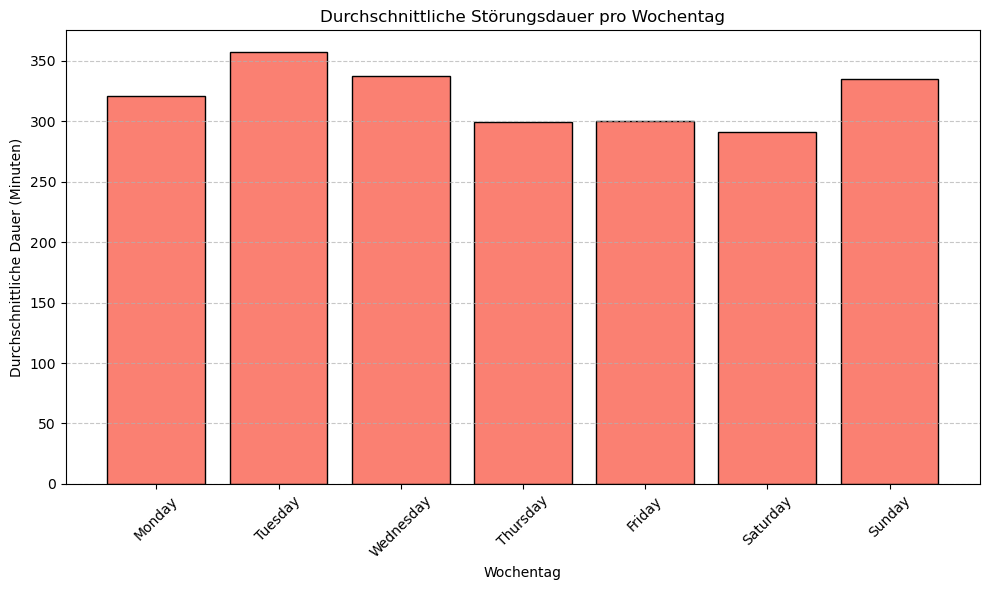

In [5]:
import matplotlib.pyplot as plt
import os
from pyspark.sql import functions as F

avg_delay_weekday = df_incidents.groupBy("weekday_num", "weekday_name") \
    .agg(F.avg("diff_seconds").alias("avg_sec")) \
    .withColumn("avg_min", F.col("avg_sec") / 60) \
    .orderBy("weekday_num") \
    .toPandas()

plt.figure(figsize=(10, 6))
plt.bar(avg_delay_weekday['weekday_name'], avg_delay_weekday['avg_min'], color='salmon', edgecolor='black')

plt.title('Durchschnittliche Störungsdauer pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittliche Dauer (Minuten)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

save_plot("avg_delay_per_weekday.png")
plt.show()

Saved: plots/delay_boxplot.png.png


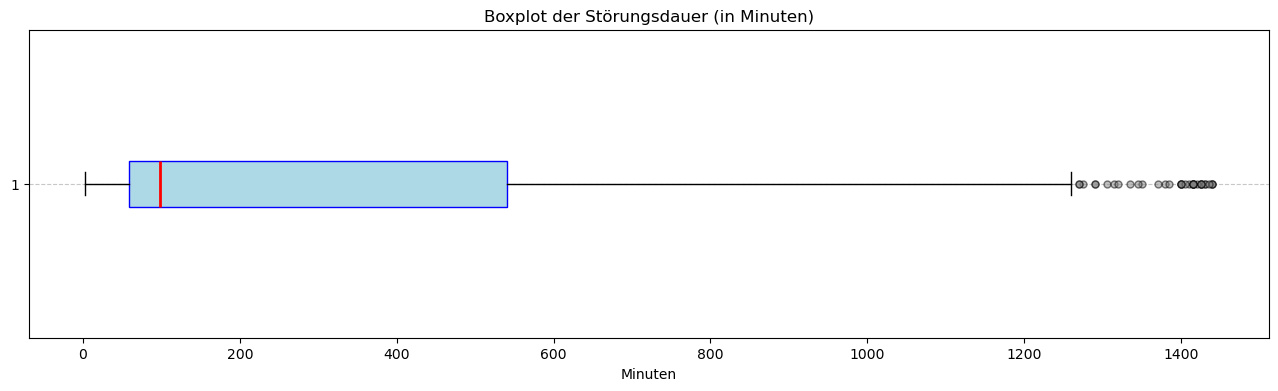

In [19]:
import matplotlib.pyplot as plt
import os
from pyspark.sql import functions as F

delay_minutes = df_incidents.select((F.col("diff_seconds") / 60).alias("minutes")).toPandas()

plt.figure(figsize=(16, 4))
plt.boxplot(delay_minutes['minutes'], 
            vert=False, 
            patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            flierprops=dict(marker='o', markerfacecolor='grey', markersize=5, alpha=0.5))

plt.title('Boxplot der Störungsdauer (in Minuten)')
plt.xlabel('Minuten')
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_plot("delay_boxplot.png")
plt.show()

Saved: plots/boxplot_stoerungsdauer_wochentag.png.png


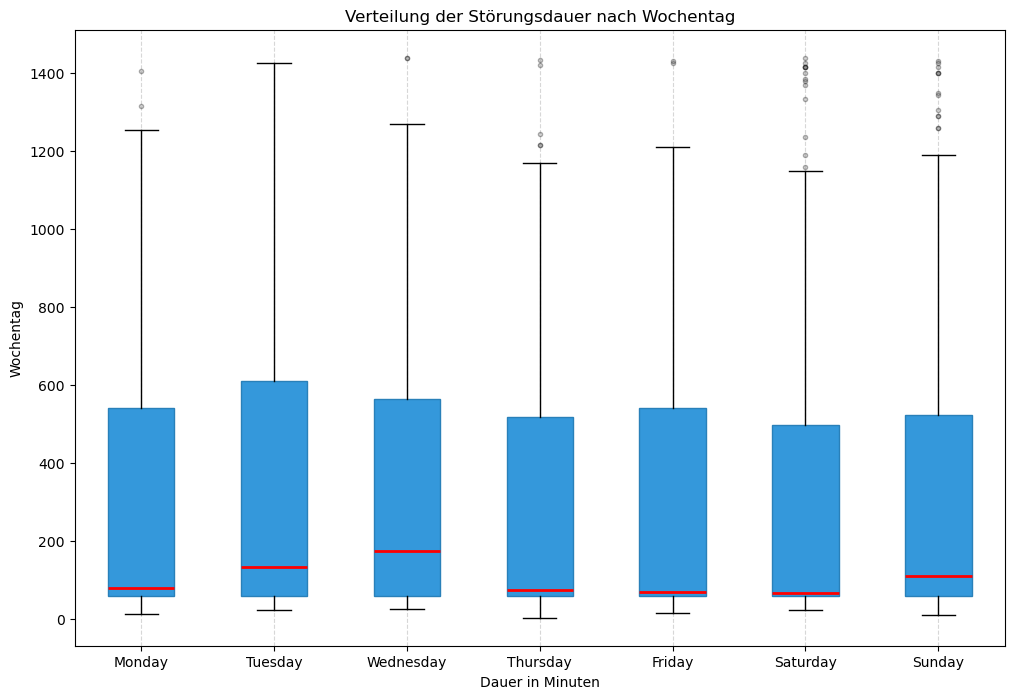

In [7]:
df_plot = df_incidents.select(
    "weekday_num", 
    "weekday_name", 
    (F.col("diff_seconds") / 60).alias("minuten")
).toPandas()

df_plot = df_plot.sort_values("weekday_num")

tage = df_plot['weekday_name'].unique()
daten_pro_tag = [df_plot[df_plot['weekday_name'] == tag]['minuten'] for tag in tage]

plt.figure(figsize=(12, 8))
plt.boxplot(daten_pro_tag, 
            vert=True,          
            labels=tage,         #weekday label
            patch_artist=True, 
            boxprops=dict(facecolor='#3498db', color='#2980b9'), # Blaues Design
            medianprops=dict(color='red', linewidth=2),          # Roter Median
            flierprops=dict(marker='o', markerfacecolor='grey', markersize=3, alpha=0.3))

plt.title('Verteilung der Störungsdauer nach Wochentag')
plt.xlabel('Dauer in Minuten')
plt.ylabel('Wochentag')
plt.grid(axis='x', linestyle='--', alpha=0.5)

save_plot("boxplot_stoerungsdauer_wochentag.png")
plt.show()

In [8]:
df_weather.printSchema()

root
 |-- _id: string (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- relative_humidity: double (nullable = true)
 |-- station_id: string (nullable = true)
 |-- sunshine_duration: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- wind_speed: double (nullable = true)



In [9]:
df_weather.limit(10).toPandas()

,_id,air_pressure,precipitation,relative_humidity,station_id,sunshine_duration,temperature,timestamp,wind_speed
0,69694bb7616de82a3e744633,993.5,0.0,78.0,HW_25,0.0,8.7,2025-11-01T00:00+00:00,0.3
1,69694bb7616de82a3e744634,993.5,0.0,79.0,HW_25,0.0,8.5,2025-11-01T00:10+00:00,0.5
2,69694bb7616de82a3e744635,993.7,0.0,80.0,HW_25,0.0,8.5,2025-11-01T00:20+00:00,1.2
3,69694bb7616de82a3e744636,993.6,0.0,82.0,HW_25,0.0,8.3,2025-11-01T00:30+00:00,0.6
4,69694bb7616de82a3e744637,993.6,0.0,82.0,HW_25,0.0,8.3,2025-11-01T00:40+00:00,0.4
5,69694bb7616de82a3e744638,993.6,0.0,82.0,HW_25,0.0,8.2,2025-11-01T00:50+00:00,0.7
6,69694bb7616de82a3e744639,993.6,0.0,83.0,HW_25,0.0,8.0,2025-11-01T01:00+00:00,0.6
7,69694bb7616de82a3e74463a,993.8,0.0,83.0,HW_25,0.0,8.4,2025-11-01T01:10+00:00,0.7
8,69694bb7616de82a3e74463b,993.8,0.0,82.0,HW_25,0.0,8.7,2025-11-01T01:20+00:00,1.2
9,69694bb7616de82a3e74463c,993.8,0.0,83.0,HW_25,0.0,8.7,2025-11-01T01:30+00:00,0.5


In [10]:
from pyspark.sql import functions as F

# Konvertierung des Wetter-Timestamps
df_weather_ready = df_weather.withColumn(
    "w_time", 
    F.to_timestamp(F.col("timestamp"), "yyyy-MM-dd'T'HH:mmXXX")
)

# Sicherheitcheck: Zeige die ersten Zeilen des konvertierten Formats
df_weather_ready.select("timestamp", "w_time").show(5, truncate=False)

+----------------------+-------------------+
|timestamp             |w_time             |
+----------------------+-------------------+
|2025-11-01T00:00+00:00|2025-11-01 00:00:00|
|2025-11-01T00:10+00:00|2025-11-01 00:10:00|
|2025-11-01T00:20+00:00|2025-11-01 00:20:00|
|2025-11-01T00:30+00:00|2025-11-01 00:30:00|
|2025-11-01T00:40+00:00|2025-11-01 00:40:00|
+----------------------+-------------------+
only showing top 5 rows



In [12]:
from pyspark.sql import functions as F

# Wir runden timestart auf das nächste 10-Minuten-Intervall
df_incidents_rounded = df_incidents.withColumn(
    "rounded_start", 
    F.from_unixtime(F.round(F.unix_timestamp("timestart") / 600) * 600).cast("timestamp")
)

In [13]:
#Right Join to not loose weather data so we have 
df_final = df_incidents_rounded.join(
    df_weather_ready, 
    df_incidents_rounded.rounded_start == df_weather_ready.w_time, 
    how="right"
)

# Wir behalten rounded_start als neue Referenzzeit und droppen die Hilfsspalte vom Wetter
df_final = df_final.drop("w_time")

df_final.limit(3).toPandas()


,PartitionKey,_id,diff_seconds,duration,endDate,name,relatedLines_data,timestart,title,weekday_name,...,rounded_start,_id,air_pressure,precipitation,relative_humidity,station_id,sunshine_duration,temperature,timestamp,wind_speed
0,None,None,NaN,None,NaT,None,None,NaT,None,None,...,NaT,69694bb7616de82a3e744633,993.5,0.0,78.0,HW_25,0.0,8.7,2025-11-01T00:00+00:00,0.3
1,None,None,NaN,None,NaT,None,None,NaT,None,None,...,NaT,69694bb7616de82a3e744634,993.5,0.0,79.0,HW_25,0.0,8.5,2025-11-01T00:10+00:00,0.5
2,None,None,NaN,None,NaT,None,None,NaT,None,None,...,NaT,69694bb7616de82a3e744635,993.7,0.0,80.0,HW_25,0.0,8.5,2025-11-01T00:20+00:00,1.2


In [14]:
df_final.printSchema()

root
 |-- PartitionKey: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- diff_seconds: long (nullable = true)
 |-- duration: string (nullable = true)
 |-- endDate: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- relatedLines_data: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- timestart: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- weekday_name: string (nullable = true)
 |-- weekday_num: integer (nullable = true)
 |-- rounded_start: timestamp (nullable = true)
 |-- _id: string (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- relative_humidity: double (nullable = true)
 |-- station_id: string (nullable = true)
 |-- sunshine_duration: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- wind_speed: double (nullable = true)



In [15]:
(df_final.write
    .format("mongodb")
    .option("spark.mongodb.write.connection.uri", "mongodb://mongodb:27017") # Explizite URI
    .option("database", "big_data_austria")
    .option("collection", "merged_weather_incidents_")
    .mode("overwrite")
    .save())

print("Safed successfully")

Safed successfully


In [21]:
spark.stop()
